# LIFE Star Catalog
## Introduction
One of the main use cases of the LIFE Target Database is to enable the creation of the LIFE Star Catalog (LIFE-StarCat). It is the stellar sample of potential targets that is used by LIFEsim to provide mission yield estimates. In this tutorial we guide you through how the 4th version of this catalog was created.

## Getting started
We start by importing the required Python modules for this tutorial.

In [1]:
import numpy as np # Used for arrays
import pyvo as vo # Used for catalog query
import astropy as ap # Used for votables

Next we import the life_td_data_generation specific functions from the modules.

In [2]:
# Self created modules
from utils import save
from provider import query

In case you don't want to download the life_td_data_generation package you can also just use the two functions below.

In [ ]:
def query(link,query,catalogs=[],no_description=True):
    """
    Performs a query via TAP on the service given in the link parameter.
    
    If a list of tables is given in the catalogs parameter,
    those are uploaded to the service beforehand.
    
    :param str link: Service access URL.
    :param str query: Query to be asked of the external database service
         in ADQL.
    :param catalogs: List of astropy tables to be uploaded to the 
        service.
    :type catalogs: list(astropy.table.table.Table)
    :param bool no_description: Defaults to True, wether description gets removed
    :returns: Result of the query.
    :rtype: astropy.table.table.Table
    """
    
    #defining the vo service using the given link
    service = vo.dal.TAPService(link)
    #without upload tables
    if catalogs==[]:
        result=service.run_async(query.format(**locals()), maxrec=1600000)
    #with upload tables
    else:
        tables={}
        for i in range(len(catalogs)):
            tables.update({f"t{i+1}":catalogs[i]})
        result = service.run_async(query,uploads=tables,timeout=None,
                                   maxrec=1600000)
    cat=result.to_table()
    
    # removing descriptions because merging of data leaves wrong description 
    for col in cat.colnames:
        if no_description:
            cat[col].description=''
    
    return cat

additional_data_path='../../additional_data/'


def save(cats,names,location=additional_data_path):
    """
    This functions saves the tables given as list in the cats parameter.
    
    :param cats: Python list of astropy table to be saved.
    :type cats: list(astropy.table.table.Table)
    :param names: Contains names for saving location
        of tables in cats.
    :type names: list(str)
    :param str location: Defaults to ../../data/additional_data/
    """
    
    #go through all the elements in both lists
    for cat,path in zip(cats,names):
        #for each column header
        for i in cat.colnames:
            if cat[i].dtype == object: #object =adaptable length string
                #transform the type into string
                cat[i] = cat[i].astype(str)
        #save the table
        ap.io.votable.writeto(
        	    ap.io.votable.from_table(cat), f'{location}{path}.xml')
    return

## Querying the Database
We will now query the LIFE Target Database (life_td) for the data needed to create the catalog. We specify the distance cut as 30 parsec according to the latest LIFE catalog version (4).

In [3]:
distance_cut=30.

Now we define the concrete query. It is one of the provided examples at http://dc.zah.uni-heidelberg.de/life/q/ex/examples. And also give the link for the service.

In [4]:
adql_query="""
    SELECT o.main_id, sb.coo_ra, sb.coo_dec, sb.plx_value, sb.dist_st_value,
        sb.sptype_string, sb.coo_gal_l, sb.coo_gal_b, sb.teff_st_value, 
        sb.mass_st_value, sb.radius_st_value, sb.binary_flag, sb.mag_i_value, 
        sb.mag_j_value,  sb.class_lum, sb.class_temp, 
        o_parent.main_id AS parent_main_id, sb_parent.sep_ang_value
    FROM life_td.star_basic AS sb
    JOIN life_td.object AS o ON sb.object_idref=o.object_id
    LEFT JOIN life_td.h_link AS h ON o.object_id=h.child_object_idref
    LEFT JOIN life_td.object AS o_parent ON 
        h.parent_object_idref=o_parent.object_id
    LEFT JOIN life_td.star_basic AS sb_parent ON 
        o_parent.object_id=sb_parent.object_idref
    WHERE o.type = 'st' AND sb.dist_st_value < """+str(distance_cut) 
service='http://dc.zah.uni-heidelberg.de/tap'

The above query returns parameters for all objects of type star with distances smaller than 30 pc.

Next we perform the actual query.

In [5]:
catalog=query(service,adql_query)

Let's have a short look at what we got:

In [6]:
print(catalog)

    main_id           coo_ra       ... parent_main_id sep_ang_value
                       deg         ...                    arcsec   
--------------- ------------------ ... -------------- -------------
    *  61 Cyg B  316.7302660185276 ...      *  61 Cyg          17.5
    *  61 Cyg A  316.7247482895925 ...      *  61 Cyg          17.5
    L 1578-44 B  324.1601460120721 ...      L 1578-44           1.0
    L 1578-44 A 324.16073469423293 ...      L 1578-44           1.0
UPM J2325+4717B  351.4090302929913 ... UPM J2325+4717            --
UPM J2325+4717A  351.4091812460812 ... UPM J2325+4717            --
     Ross  200B  325.0050669305063 ...      Ross  200           1.2
            ...                ... ...            ...           ...
      Ross 1051 226.07709920323748 ...                           --
 PM J18087-2632 272.19806065879413 ...                           --
 PM J11117-5620 167.94598029396457 ...                           --
 UPM J1635-5202 248.90500288957998 ...          

We can see that we obtained a table of about 10'000 stars.

## Processing the result
### Removing non main-sequence stars
For the LIFE mission we are only interested in main sequence stars so in the next step we remove all other stars. We first remove those without main sequence temperature classes (e.g. white dwarfs). 

In [7]:
ms_tempclass=np.array(['O','B','A','F','G','K','M'])
cat_ms_tempclass=catalog[np.where(np.in1d(catalog['class_temp'],ms_tempclass))]

Next we remove objects that are not main sequence in luminocity class.

In [8]:
ms_lumclass=np.array(['V'])
cat_ms_lumclass=cat_ms_tempclass[np.where(np.in1d(cat_ms_tempclass['class_lum'],ms_lumclass))]
print(cat_ms_lumclass)

   main_id           coo_ra       ... parent_main_id sep_ang_value
                      deg         ...                    arcsec   
-------------- ------------------ ... -------------- -------------
   *  61 Cyg B  316.7302660185276 ...      *  61 Cyg          17.5
   *  61 Cyg A  316.7247482895925 ...      *  61 Cyg          17.5
   L 1578-44 A 324.16073469423293 ...      L 1578-44           1.0
    HD 239960B  336.9991483422729 ...      HD 239960          71.9
    HD 239960A  336.9981564512275 ...      HD 239960          71.9
     HD 179958 288.02093934795624 ...    BD+49  2959         196.0
     HD 179957 288.01949584708956 ...    BD+49  2959         196.0
           ...                ... ...            ...           ...
     LP  762-3 348.04710312658415 ...                           --
      G  88-37    113.12901513156 ...                           --
PM J13306-2039 202.67061817480206 ...                           --
     Ross 1051 226.07709920323748 ...                         

Now for the final catalog we want to have stellar mass values for each object. Currently the database is not able to assign model masses to some of the spectral types. This is the case when instad of M3.0V something like dM3.0, M or M (3) V is given in sptype_string. This will be implemented in one of the future database releases but for now we will just remove all objects without entries in mass_st_value.

In [9]:
print(cat_ms_lumclass['main_id', 'mass_st_value','sptype_string'][cat_ms_lumclass['mass_st_value'].mask.nonzero()[0]])
cat_ms_lumclass.remove_rows(cat_ms_lumclass['mass_st_value'].mask.nonzero()[0])

        main_id         mass_st_value sptype_string
                           solMass                 
----------------------- ------------- -------------
             LP  546-51            --             M
       UCAC3 190-156729            --             M
               G 123-49            --        M2.5Ve
         SCR J1639-4652            --            MV
              L   60-13            --             M
        UCAC2   1564860            --             M
              L  443-59            --             M
                    ...           ...           ...
            CD-34  1169            --             M
               G 111-52            --             M
            PG 0943+489            --           dMe
        LSPM J1954+1738            --             M
            [LM84] 5-47            --             M
              HD 170209            --         K(2)V
             [BEM91] 11            --            MV
2MASS J05171315-7706040            --             M
Length = 27 

wait, we want to assume main sequence if nothing is given... and then I could also get masses for them... but I wouldn't necessary have it in the db...
I faintly remember we were also interested in IV stars, but can't remember why. tried to look it up in the paper but couldn't find it. maybe in the report?
"We did, however, keep the ones with no luminocity class given assuming them to be main sequence stars. This is justified as the main sequence is the longest lasting evolutionary period of a star leaving the great majority of stars in this stage." states why the assumption of main sequence is ok.
found out we only included main sequence for modeling reasons. so I need to exclude all else and therefore also found a bug from StarCat4

### removing higher order multiples
For the LIFE catalog we want single stars and wide binaries that can be approximated as single stars. For that we now split the sample into single and multiple stars:

In [10]:
singles=cat_ms_lumclass[np.where(cat_ms_lumclass['binary_flag']=='False')]
multiples=cat_ms_lumclass[np.where(cat_ms_lumclass['binary_flag']=='True')]
print(len(singles),len(multiples))

3495 2244


Next we remove higher order multiples. That means we remove systems like shown in the nextled multiples part of the following figure:
![title](multiplicity.png)

To do that we first remove those objects, where the parent object is a child object as well. In the example above that would be "system AB". For that we need to get the hierarchy table from life_td. 

In [11]:
adql_query2="""
    SELECT o.main_id as child_main_id,o.object_id
    FROM life_td.object AS o
    JOIN life_td.h_link AS h on o.object_id=h.child_object_idref
    """
h_link=query(service,adql_query2)

In [12]:
higher_order_multiples=np.in1d(multiples['parent_main_id'],\
        h_link['child_main_id'])
multiples.remove_rows(higher_order_multiples)

where multiple parent objects for one object given e.g. *  9 Aur has as parent WDS J05067+5136AB, WDS J05067+5136AC and WDS J05067+5136AE given.

In [13]:
multi_parent=[]
grouped=multiples.group_by('main_id')
ind=grouped.groups.indices
for i in range(len(ind)-1):
    if ind[i+1]-ind[i]!=1:
        multi_parent.append(grouped['main_id'][ind[i]])

single_parent_multiples=grouped[np.where(np.invert(np.in1d(grouped['main_id'],multi_parent)))]
print(len(single_parent_multiples))

1031


since we want to get wide binaries the next step is to have a look at the given separation values. Removing those binaries where no separation value given

In [14]:
sep_multiples=single_parent_multiples[np.where(single_parent_multiples['sep_ang_value'].mask==False)].copy()

Transforming from angular separation into physical one

In [15]:
sep_multiples['sep_phys_value']=sep_multiples['sep_ang_value']#just initiating new column with same properties 
sep_multiples['sep_phys_value'].unit=ap.units.AU
for i in range(len(sep_multiples)):
    sep_multiples['sep_phys_value'][i]=np.round(
            sep_multiples['sep_ang_value'][i]*sep_multiples['dist_st_value'][i],1)

Keeping only binaries where both components fulfill requirements.
 meaning having the parameters we need for critical sep 
 computation (main sequence & sep given)

In [16]:
grouped_multiples=sep_multiples.group_by('parent_main_id')
ind=grouped_multiples.groups.indices

result=grouped_multiples[:0].copy()

for i in range(len(ind)-1):
    l=ind[i+1]-ind[i]
    if l==2:
        result.add_row(grouped_multiples[ind[i]])
        result.add_row(grouped_multiples[ind[i]+1])

In [17]:
print(len(result))

478


### Wide binaries
Now we actually focus on the wide binaries. This means we keep only objects where <10 AU planet orbits are stable. For that we use the formula from Holman and Wiegert 1999 while assuming circular orbits and neglegt projection effects of the bianry separations.
The following function computes the critical separation beyond which a planet on a S-type orbit is not stable any more.

In [18]:
def crit_sep(eps,mu,a_bin):
    """
    Computes critical semimajor-axis for planet orbit stability.

    For binary system as described in Holman and Wiegert 1999.

    :param eps: Binary orbit excentricity.
    :type eps:
    :param mu: mass fraction with mu=m_s/(m_p+m_s), with m_s the mass 
        of the star considered as perturbing binary companion and m_p 
        the mass of the star the planet is orbiting.
    :type mu:
    :param a_bin: semimajor-axis of the binary stars.
    :type a_bin:
    :returns: Critical separation beyond which a planet on a S-type 
        orbit (circumstellar) and on a P-type orbit (circumbinary) is 
        not stable any more.
    :rtype: 
    """
    a_crit_s=(0.464-0.38*mu-0.631*eps+0.586*mu*eps+0.15*eps**2\
              -0.198*mu*eps**2)*a_bin
    a_crit_p=(1.6+5.1*eps-2.22*eps**2+4.12*mu-4.27*eps*mu-5.09*mu**2\
              +4.61*eps**2*mu**2)*a_bin
    return a_crit_s,a_crit_p

Now we assign the critical separation to each binary component.

In [19]:
result['a_crit_s']=result['sep_phys_value']#initializing column a... like sep...

for i in range(len(result)):
    m_p=result['mass_st_value'][i]
    if i % 2 == 0:
        m_s=result['mass_st_value'][i+1]
    else:
        m_s=result['mass_st_value'][i-1]
    mu=m_s/(m_p+m_s)
    result['a_crit_s'][i]=crit_sep(0,mu,result['sep_phys_value'][i])[0]
    #assumed circular orbit and sep_phys = a_bin

Next we keep only those where orbits up to 10AU are stable.

In [20]:
final=result[:0].copy()
#wait, didn't I already define this? -> was before removing some
ind=result.group_by('parent_main_id').groups.indices
a_max=10.

for i in range(len(ind)-1):
    if a_max < min(result['a_crit_s'][ind[i]],result['a_crit_s'][ind[i]+1]):
        final.add_row(result[ind[i]])
        final.add_row(result[ind[i]+1])

In [21]:
print(len(final))

424


now combining singles and multiples into one sample again

In [22]:
StarCat4=ap.table.vstack([singles,final])

### adding architecture parameter
For mission design trade space we are interested in the ability to take subsamples of the stars depending on ecliptic angle. 

In [23]:
def ecliptic(ang,ra,dec):
    """
    Computes if position is within angle from the ecliptic.
    
    Flag any object whose declination is contained within the region 
    between -(23.4+angle)*sin(RA) and +(23.4+angle)*sin(RA) with the 
    object's RA in degrees.

    :param ang: Angle in degrees.
    :type ang:
    :param ra: Right ascention in degrees.
    :type ra: np.array
    :param dec: Array of declination in degrees.
    :type dec: np.array
    :returns: Flags.
    :rtype: np.array
    """
    ecliptic=(23.4)*np.sin(2*np.pi*ra/360)
    flag=['True' if dec[j] > -ang+ecliptic[j] and dec[j] < ang+ecliptic[j] \
            else 'False' for j in range(len(ra))]
    return flag

StarCat4['ecliptic_pm45deg']=ecliptic(45,StarCat4['coo_ra'],\
        StarCat4['coo_dec'])

showing and saving

In [24]:
print(StarCat4)
#add final plot
save([StarCat4],['StarCat4'])

    main_id           coo_ra       ...      a_crit_s      ecliptic_pm45deg
                       deg         ...         AU                         
--------------- ------------------ ... ------------------ ----------------
 PM J17198+2833    259.96283461373 ...                 --            False
SIPS J0004-2058 1.1727816434729168 ...                 --             True
 PM J16299+0453    247.47772620577 ...                 --             True
      L  372-58 53.998746505525006 ...                 --            False
 PM J23229+3717  350.7432076933599 ...                 --             True
      Ross  324  19.46095056389333 ...                 --             True
      Wolf 1506  15.32345014843625 ...                 --             True
            ...                ... ...                ...              ...
     AG+14 2584    347.47892010478 ... 178.16432826842234             True
      HD 218687    347.48792009444 ...  254.3978378161175             True
    BD-20  6558 348.56928

Now let's have a small look at the distance and spectral type distribution of our catalog:

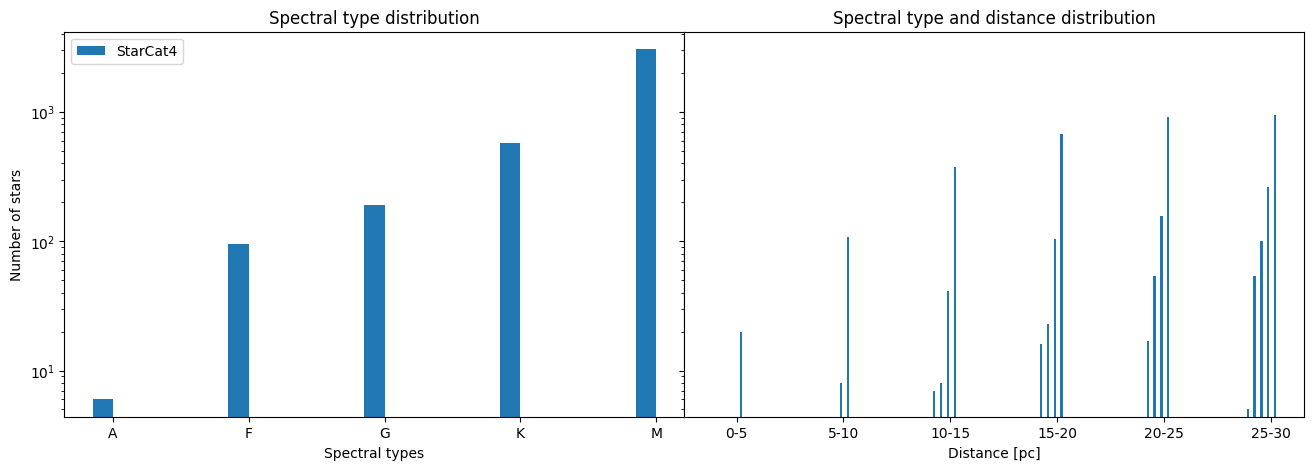

In [27]:
from analysis import final_plot

final_plot([StarCat4['class_temp','dist_st_value']],['StarCat4'],distance_cut)

## Summary

The stellar sample was compiled from querying the LIFE database (Menti et al. 2021) for stellar objects within 30 pc. Appart from the new source we tried to keep the criteria for inclusion into the catalog as similar to the ones from the previous LIFE catalog version as possible. This allows us to compare the two versions better before changing the criteria in the next catalog version (LIFE-StarCat5) again. (Among others to include higher order systems since they could have better chances for hosting life but in current version not included due to complexity e.g. centaury system). We started by removed objects with luminosity class I, II and III as we focused on main-sequence stars (or close to). In case no luminosity class was given we assumed the objects were main-sequence objects. In order to assess which objects are members of binary or multiple systems we used the LIFE database's hierarchical link. This feature connects an object with its parent and child objects. We therefore removed objects which were neither single stars nor trivial binaries. Concretely we removed objects where either the parent object of the star is istself a child object of another system, where multiple parent objects were given for the same star or which had more than one companion. As a note of caution this classification in the LIFE database is heavily based on Washington Visual Double Star Catalog (WDS; Mason et al. 2001) which in term only describes visual multiples and therefore contains some objects that are not physically bound. We also removed objects with incomplete information for the stellar parameters (this step also included binaries, where one component was not listed as a main-sequence star) or no separation between the binaries was given. In order to ensure that all stellar components of the remaining binary systems could harbor stable planetary systems between 0.5 and 10 AU we transformed the angular separation into physical and used it together with the stability criterion from Holman & Wiegert (1999) that takes into account the stellar masses, their separation and the eccentricity of the binary orbit (which we assumed to be zero). Systems that did not fulfill this stability criterion were removed. Finally we introduced a new parameter for future mission architecture analysis in which we flag objects that are contained within \pm 45 degrees of the ecliptic plane. This simulates the loss of targets by not full sky field of view. The catalog consists of 3909 stars in total (434 wide binary components and 3475 single stars).